# LSTM PORTFOLIO OPTIMIZATION

In [1]:
# setup
import pandas as pd
import yfinance as yf
import datetime


The data used in this study was collected from Yahoo Finance through the yfinance API for the 10year period of 5/6/2013 to 5/2/2023. The chosen universe consists of ['GOOGL', 'AAPL', 'MSFT', 'DIS', 'WBD', 'V', 'JNJ', 'PG', 'AMZN', 'UNH', 'HD', 'CVX']. 

## Extract

In [2]:
tickers = ['GOOGL', 'AAPL', 'MSFT', 'DIS', 'WBD', 'V', 'JNJ', 'PG', 'AMZN', 'UNH', 'HD', 'CVX']
#fixed 10y period
start_date = datetime.datetime(2013, 5, 6)
end_date = datetime.datetime(2023, 5, 2)

data = yf.download(tickers = tickers,  
            #period = "10y",    
            start = start_date,
            end = end_date,     
            interval = "1wk",       
            prepost = False,       
            repair = True)  

data = data['Close']

[*********************100%%**********************]  12 of 12 completed


In [3]:
data.head() 

,AAPL,AMZN,CVX,DIS,GOOGL,HD,JNJ,MSFT,PG,UNH,V,WBD
Date,,,,,,,,,,,,
2013-05-06,16.177500,13.1815,123.230003,67.199997,22.027779,76.010002,85.760002,32.689999,78.760002,62.910000,44.687500,40.204395
2013-05-13,15.473571,13.4950,123.419998,66.580002,22.752253,76.860001,88.089996,34.869999,80.019997,62.840000,46.142502,40.291264
2013-05-20,15.898214,13.0870,125.449997,65.489998,21.854855,78.989998,86.820000,34.270000,81.879997,62.060001,45.112499,40.638733
2013-05-27,16.061787,13.4600,122.750000,63.080002,21.802301,78.660004,84.180000,34.900002,76.760002,62.630001,44.535000,40.301483
2013-06-03,15.778929,13.8435,121.699997,64.849998,22.015265,78.739998,84.910004,35.669998,77.750000,62.570000,44.985001,39.034237


In [4]:
# train test split
split_idx = int(len(data) * 0.8)
train_df = data.iloc[:split_idx]
remaining_df = data.iloc[split_idx:]
split_idx_2 = int(len(remaining_df) * 0.5)
validation_df = remaining_df.iloc[:split_idx_2+1]
test_df = remaining_df.iloc[split_idx_2+1:]

In [5]:
print(f'train dates: {min(train_df.index).strftime("%Y-%m-%d")} to {max(train_df.index).strftime("%Y-%m-%d")}')
print(f'validation dates: {min(validation_df.index).strftime("%Y-%m-%d")} to {max(validation_df.index).strftime("%Y-%m-%d")}')
print(f'test dates: {min(test_df.index).strftime("%Y-%m-%d")} to {max(test_df.index).strftime("%Y-%m-%d")}')
# 10 year period - 8 train, 1 test, 1 validation 

train dates: 2013-05-06 to 2021-04-26
validation dates: 2021-05-03 to 2022-05-02
test dates: 2022-05-09 to 2023-05-01


In [6]:
#checking if there are missing values
data.isna().value_counts()

AAPL   AMZN   CVX    DIS    GOOGL  HD     JNJ    MSFT   PG     UNH    V      WBD  
False  False  False  False  False  False  False  False  False  False  False  False    522
Name: count, dtype: int64

no missing values found

## LSTM 


In [7]:
# LSTM setup
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.base import BaseEstimator, TransformerMixin
from keras import regularizers

In [8]:
# LSTM with some modifications but no CNN or bidirectional 
# Normalize the input features
class CustomMinMaxScaler(BaseEstimator, TransformerMixin):
     def __init__(self, feature_range=(0, 1)):
         self.feature_range = feature_range
 
     def fit(self, X, y=None):
         data_min = np.nanmin(X, axis=0)
         data_max = np.nanmax(X, axis=0)
         self.scale_ = (self.feature_range[1] - self.feature_range[0]) / (data_max - data_min)
         self.scale_[data_max == data_min] = 1.0
         self.min_ = self.feature_range[0] - data_min * self.scale_
         return self
 
     def transform(self, X):
         return X * self.scale_ + self.min_
 
     def inverse_transform(self, X):
         return (X - self.min_) / self.scale_


# Combine the data frames into one data frame
combined_df = pd.concat([train_df, test_df, validation_df], axis=0)

# Scale the combined data set
scaler = CustomMinMaxScaler(feature_range=(0, 1))
combined_df_sc = scaler.fit_transform(combined_df)
combined_df_sc.head()

# Split the scaled data back into train, test, and validation data sets
train_df_sc = combined_df_sc[:len(train_df)]
test_df_sc = combined_df_sc[len(train_df):len(train_df)+len(test_df)]
validation_df_sc = combined_df_sc[len(train_df)+len(test_df):]

# Create new DataFrames with the scaled data and original column names
train_df_sc = pd.DataFrame(train_df_sc, columns=train_df.columns, index=train_df.index)
test_df_sc = pd.DataFrame(test_df_sc, columns=test_df.columns, index=test_df.index)
validation_df_sc = pd.DataFrame(validation_df_sc, columns=validation_df.columns, index=validation_df.index)

def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps + 1):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps-1])
    return np.array(Xs), np.array(ys)

# Set the time steps for LSTM
time_steps = 52

In [9]:
# scaling works... 
train_df_sc.head()

,AAPL,AMZN,CVX,DIS,GOOGL,HD,JNJ,MSFT,PG,UNH,V,WBD
Date,,,,,,,,,,,,
2013-05-06,0.012195,0.000547,0.502400,0.046725,0.006530,0.009659,0.025835,0.004937,0.108659,0.001738,0.006829,0.455718
2013-05-13,0.007936,0.002360,0.503895,0.042177,0.012202,0.012139,0.049349,0.011925,0.121900,0.001595,0.013901,0.456994
2013-05-20,0.010505,0.000000,0.519871,0.034182,0.005176,0.018354,0.036532,0.010001,0.141446,0.000000,0.008895,0.462096
2013-05-27,0.011495,0.002158,0.498623,0.016504,0.004765,0.017391,0.009890,0.012021,0.087642,0.001165,0.006088,0.457144
2013-06-03,0.009784,0.004376,0.490360,0.029487,0.006432,0.017625,0.017257,0.014489,0.098045,0.001043,0.008275,0.438535


In [10]:
forecasts = {}
verbose = 0

for ticker in train_df.columns:
    if ticker == 'SPY':
        continue
    print(f"Processing {ticker}...")
    # Get the index of the ticker column
    ticker_idx = list(train_df.columns).index(ticker)

    # Drop the ticker column from the DataFrames
    train_data_X = train_df_sc.drop(columns=[ticker])
    train_data_Y = train_df_sc[ticker]
    test_data_X = test_df_sc.drop(columns=[ticker])
    test_data_Y = test_df_sc[ticker]
    validation_data_X = validation_df_sc.drop(columns=[ticker])
    validation_data_Y = validation_df_sc[ticker]

    # Reshape the input data to 3D array (samples, time_steps, features)
    X_train, y_train = create_dataset(pd.DataFrame(train_data_X), train_data_Y, time_steps)
    X_test, y_test = create_dataset(pd.DataFrame(test_data_X), test_data_Y, time_steps)

    # Define the LSTM model architecture
    model = Sequential()
    model.add(LSTM(64, activation='tanh', recurrent_activation = 'selu',kernel_initializer="glorot_uniform",
    recurrent_initializer="orthogonal", activity_regularizer = regularizers.l1_l2(0.000001, 0.000005), return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(SpatialDropout1D(0.15))
    model.add(Dense(1))

    # Compile the LSTM model
    model.compile(optimizer='adam', loss='mae', run_eagerly=True)

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    X_val, y_val = create_dataset(pd.DataFrame(validation_data_X), validation_data_Y, time_steps)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_val, y_val), verbose=verbose, shuffle=False, callbacks=[early_stopping])

    # Make predictions
    test_data_X = test_data_X.values.reshape((test_data_X.shape[0]//(time_steps), time_steps, test_data_X.shape[1]))
    y_pred = model.predict(test_data_X)
    forecasts[ticker] = scaler.inverse_transform(y_pred)


Processing AAPL...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 288ms/step
Processing AMZN...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 140ms/step
Processing CVX...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 144ms/step
Processing DIS...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 146ms/step
Processing GOOGL...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 144ms/step
Processing HD...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 132ms/step
Processing JNJ...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 117ms/step
Processing MSFT...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 133ms/step
Processing PG...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 112ms/step
Processing UNH...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 133ms/step
Processing V...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 117ms/step
Processing WBD...


C:\Users\hp\AppData\Local\Temp\ipykernel_18176\1711032859.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i+time_steps-1])


1/1 [==============================] - 0s 119ms/step


In [11]:
print(f"Number of keys in the dictionary: {len(forecasts)}")
print(f"List of keys: {list(forecasts.keys())}")
for key in forecasts:
    print(key, forecasts[key].shape)

# For each series we have 52 (weekly) forecasts [13 is total number of series including explanatory ones and the target]

Number of keys in the dictionary: 12
List of keys: ['AAPL', 'AMZN', 'CVX', 'DIS', 'GOOGL', 'HD', 'JNJ', 'MSFT', 'PG', 'UNH', 'V', 'WBD']
AAPL (1, 52, 12)
AMZN (1, 52, 12)
CVX (1, 52, 12)
DIS (1, 52, 12)
GOOGL (1, 52, 12)
HD (1, 52, 12)
JNJ (1, 52, 12)
MSFT (1, 52, 12)
PG (1, 52, 12)
UNH (1, 52, 12)
V (1, 52, 12)
WBD (1, 52, 12)


In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

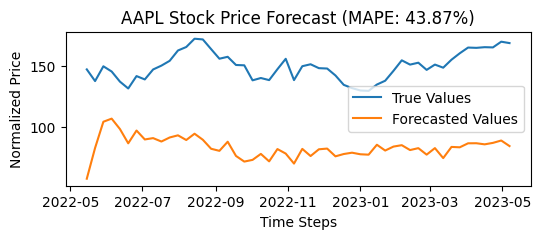

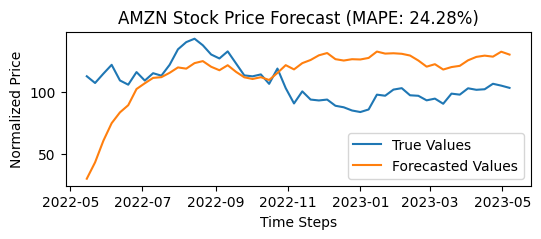

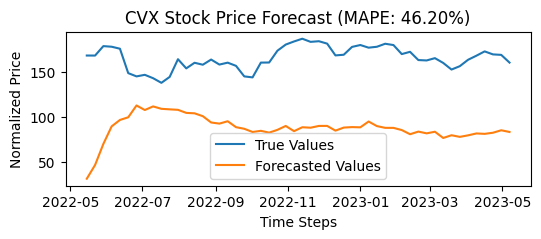

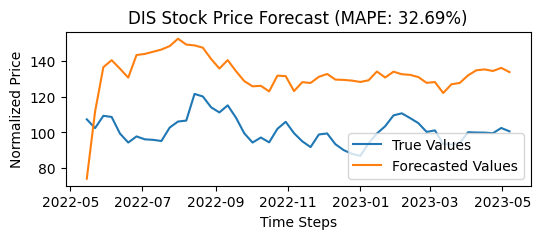

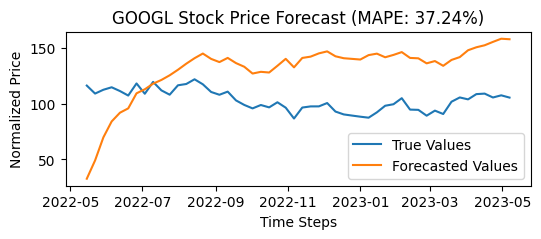

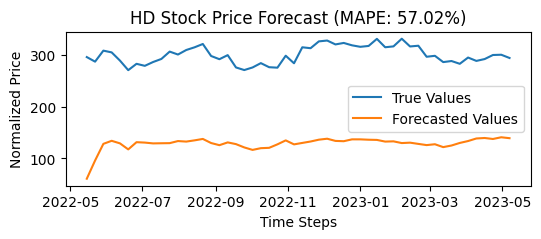

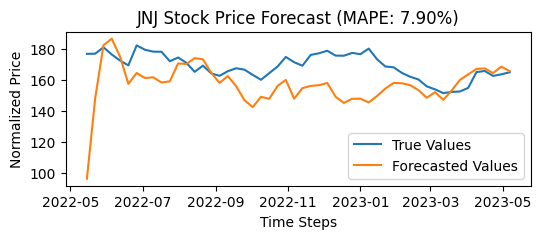

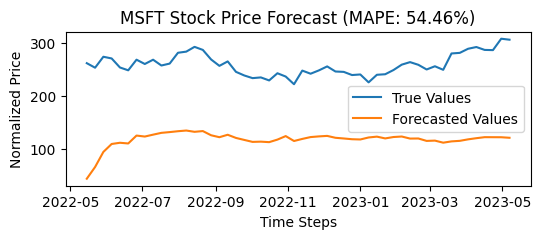

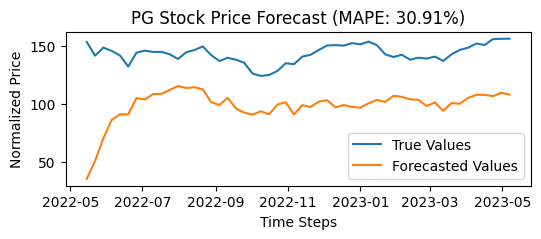

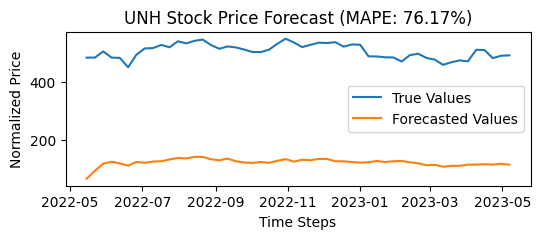

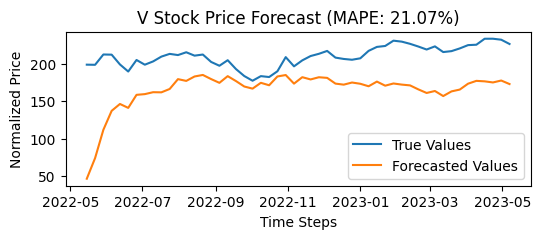

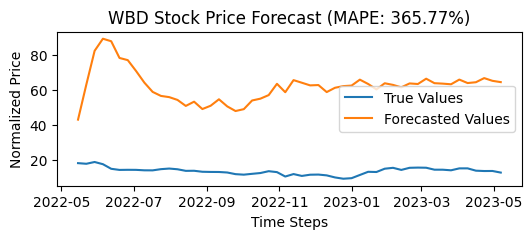

In [13]:
# Define the start and end dates of the test data
start_date = test_df.index[0]
end_date = test_df.index[-1]

# Extend the date range
new_end_date = end_date + pd.DateOffset(weeks=1) # Extend by 1
date_range = pd.date_range(start=start_date, end=new_end_date, freq='W')

# Loop through the dictionary and extract the forecasts for each series
for key in forecasts:
    # Extract the forecasted values for the current series
    forecast_values = forecasts[key][0, :, 0].flatten()
    # Extract the true values for the current series
    true_values = test_df[key]
    # Calculate the MAPE for the current series
    mape = mean_absolute_percentage_error(true_values, forecast_values)
    
    # Plot the forecasted values against the true values for the current series
    plt.figure(figsize=(6, 2))
    plt.plot(date_range, true_values, label='True Values')
    plt.plot(date_range, forecast_values, label='Forecasted Values')
    plt.title(f'{key} Stock Price Forecast (MAPE: {100*mape:.2f}%)')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()


LSTM + CNN

In [14]:
from tensorflow.keras.layers import GRU, Bidirectional, TimeDistributed, Conv1D, SpatialDropout1D
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
forecasts_4 = {}
verbose = 0

for ticker in train_df.columns:
    if ticker == 'SPY':
        continue
    print(f"Processing {ticker}...")
    # Get the index of the ticker column
    ticker_idx = list(train_df.columns).index(ticker)

    # Drop the ticker column from the DataFrames
    train_data_X = train_df_sc.drop(columns=[ticker])
    train_data_Y = train_df_sc[ticker]
    test_data_X = test_df_sc.drop(columns=[ticker])
    test_data_Y = test_df_sc[ticker]
    validation_data_X = validation_df_sc.drop(columns=[ticker])
    validation_data_Y = validation_df_sc[ticker]

    # Reshape the input data to 3D array (samples, time_steps, features)
    X_train, y_train = create_dataset(pd.DataFrame(train_data_X), train_data_Y, time_steps)
    X_test, y_test = create_dataset(pd.DataFrame(test_data_X), test_data_Y, time_steps)

    # Define the model architecture
    model = Sequential()
    model.add(Conv1D(52, kernel_size=4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(84, activation='tanh', recurrent_activation='selu', kernel_initializer="glorot_uniform",
                   recurrent_initializer="orthogonal", recurrent_dropout=0.03, return_sequences=True))
    model.add(Bidirectional(GRU(64, activation='tanh', return_sequences=True)))
    model.add(SpatialDropout1D(0.1))
    model.add(TimeDistributed(Dense(1)))

    # Compile the model
    model.compile(optimizer='adam', loss='mae', run_eagerly=True)

    # Define the early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

    X_val, y_val = create_dataset(pd.DataFrame(validation_data_X), validation_data_Y, time_steps)

    # Train the model
    history = model.fit(X_train, y_train, epochs=100, batch_size=20, validation_data=(X_val, y_val), verbose=verbose, shuffle=False, callbacks=[early_stopping])

    # Make predictions
    test_data_X = test_data_X.values.reshape((test_data_X.shape[0] // (time_steps), time_steps, test_data_X.shape[1]))
    y_pred = model.predict(test_data_X).flatten()
    y_pred_2d = y_pred.reshape(-1, 1)
    forecasts_4[ticker] = scaler.inverse_transform(y_pred_2d)

    # Adjust the true values to match the length of the predicted values
    test_data_Y_adjusted = test_data_Y[-len(y_pred):]

    # Calculate the mean absolute error
    mape = mean_absolute_percentage_error(test_data_Y_adjusted, y_pred)

    # Print the mean absolute error
    print(f"Mean Absolute Percentage Error for {ticker}: {mape}")

    # Plot the forecasted values against the true values for the current series
    plt.figure(figsize=(6, 2))
    plt.plot(date_range[-len(y_pred):], test_data_Y_adjusted, label='True Values')
    plt.plot(date_range[-len(y_pred):], y_pred, label='Forecasted Values')
    plt.title(f'{ticker} Stock Price Forecast (MAPE: {100 * mape:.2f}%)')
    plt.xlabel('Time Steps')
    plt.ylabel('Normalized Price')
    plt.legend()
    plt.show()


In [17]:
print(f"Number of keys in the dictionary: {len(forecasts_4)}")
print(f"List of keys: {list(forecasts_4.keys())}")
for key in forecasts_4:
    print(key, forecasts_4[key].shape)

Number of keys in the dictionary: 3
List of keys: ['AAPL', 'AMZN', 'CVX']
AAPL (49, 12)
AMZN (49, 12)
CVX (49, 12)


- AAPL best model is 2 and it gives mape of 0.0858 [as decimal]
- AMZN best model is 1 and it gives mmape of 0.2691 [as decimal]
- CVX best model is 1 and it gives mape of 0.1891 [as decimal]
- DIS best model is 1 and it gives mape of 0.1594 [as decimal]
- GOOGL best modeel is 2 and it gives mape 0.05760 [as decimal]
- HD best model is 4 and it gives mape of 0.088177 [as decimal]
- JNJ best model is 3 and it gives mape of 0.06540 [as decimal]
- MSFT best model is 4 and it gives mape of 0.167895 [as decimal]
- PG bst model is 2 and it gives mape of 0.2523 [as decimal]
- UNH best model is 4 and it gives mape of 0.422042 [as decimal] 
- V best is model 4 and it gives mape of 0.13178 [as decimal] 
- WBD best is model 4 and it gives mape of 0.21950 [as decimal] 

- Could pick portfolio of Apple, Google, HD, JNJ, and safe asset (cash) to make use of only assets we can forecast with mape < 0.1 [as decimal] or 10%

# MVP Portfolio optimization
Logic: 
- Calculate the expected returns and risks of each asset using historical data and statistical methods.
- Construct an efficient frontier, which is a set of portfolios that maximizes the expected return for a given level of risk or minimizes the risk for a given level of expected return.
- Select the optimal portfolio from the efficient frontier based on the investor's risk tolerance and expected return goals.
- note: please see Baseline_Modern_Theoretical_Portfolios_Construction_and_Results.ipynb for further detailed model description and usage. 




In [18]:
#setup
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display

from typing import List, Tuple
from functools import cache  # Python 3.9 required
import warnings
warnings.filterwarnings('ignore')

In [19]:
TREASURY_BILL_RATE = 0.0208 # as of 5/08/2022 (start of test set)
TRADING_DAYS_PER_YEAR = 52

In [20]:
# Needed for type hinting
class Asset:
    pass

def get_log_period_returns(price_history: pd.DataFrame):
    #close = price_history['Close'].values  
    close = price_history.values
    return np.log(close[1:] / close[:-1]).reshape(-1, 1)

# daily_price_history has to at least have a column, called 'Close'
class Asset:
    def __init__(self, name: str, daily_price_history: pd.DataFrame):
        self.name = name
        self.daily_returns = get_log_period_returns(daily_price_history)
        self.expected_daily_return = np.nanmean(self.daily_returns)

    @property
    def expected_return(self):
        return TRADING_DAYS_PER_YEAR * self.expected_daily_return

    def __repr__(self):
        return f'<Asset name={self.name}, expected return={self.expected_return}>'

    @staticmethod
    @cache
    def covariance_matrix(assets: Tuple[Asset]):  # tuple for hashing in the cache
        product_expectation = np.zeros((len(assets), len(assets)))
        for i in range(len(assets)):
            for j in range(len(assets)):
                if i == j:
                    product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
                else:
                    product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)

        product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

        expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
        product_of_expectations = expected_returns @ expected_returns.T

        return product_expectation - product_of_expectations


    def random_weights(weight_count):
        weights = np.random.random((weight_count, 1))
        weights /= np.sum(weights)
        return weights.reshape(-1)


class Portfolio:
    def __init__(self, assets: Tuple[Asset]):
        self.assets = assets
        self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
        self.covariance_matrix = Asset.covariance_matrix(assets)
        self.weights = Asset.random_weights(len(assets))
        
    def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float):
        weights = Asset.random_weights(self.weights.size)
        res = minimize(
          lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
          Asset.random_weights(self.weights.size),
          constraints=[
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
          ],
          bounds=[(0., 1.) for i in range(self.weights.size)]
        )
    
        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def optimize_with_risk_tolerance(self, risk_tolerance: float):
        assert risk_tolerance >= 0.
        return self.unsafe_optimize_with_risk_tolerance(risk_tolerance)

    def optimize_with_expected_return(self, expected_portfolio_return: float):
        res = minimize(
          lambda w: self._variance(w),
          Asset.random_weights(self.weights.size),
          constraints=[
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
            {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
          ],
          bounds=[(0., 1.) for i in range(self.weights.size)]
        )

        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def optimize_sharpe_ratio(self):
        # Maximize Sharpe ratio = minimize minus Sharpe ratio
        x0 = Asset.random_weights(self.weights.size)
        res = minimize(
          lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w)),
          x0,
          constraints=[
            {'type': 'eq', 'fun': lambda w: np.sum(w) if np.sum(w) <= 1. else np.sum(w) - 1.},
          ],
          bounds=[(0., 1.) for i in range(self.weights.size)],
        )

        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def _expected_return(self, w):
        return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]

    def _variance(self, w):
        return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

    @property
    def expected_return(self):
        return self._expected_return(self.weights)

    @property
    def variance(self):
        return self._variance(self.weights)

    def __repr__(self):
        return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'

In [21]:
# combine train and validation sets for base MVO portfolio to create weights on test set
mvo_df = pd.concat([train_df, validation_df], axis=0)

In [22]:
assets = []
for i in range(len(tickers)):
    assets.append(Asset(mvo_df.columns[i],mvo_df[mvo_df.columns[i]]))
assets = tuple(assets)
assets

(<Asset name=AAPL, expected return=0.25217297716736115>,
 <Asset name=AMZN, expected return=0.23994701889279374>,
 <Asset name=CVX, expected return=0.03612242698120394>,
 <Asset name=DIS, expected return=0.05493152123275391>,
 <Asset name=GOOGL, expected return=0.18395117714239406>,
 <Asset name=HD, expected return=0.1500980206910455>,
 <Asset name=JNJ, expected return=0.07994377010788276>,
 <Asset name=MSFT, expected return=0.2360200900625214>,
 <Asset name=PG, expected return=0.07577705281551494>,
 <Asset name=UNH, expected return=0.22974716154457756>,
 <Asset name=V, expected return=0.1677110987116418>,
 <Asset name=WBD, expected return=-0.09064972726858467>)

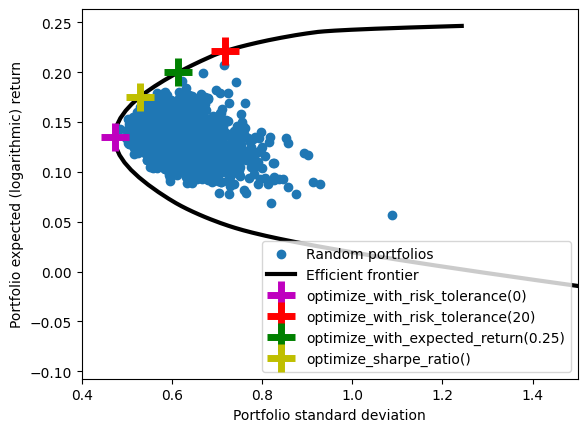

In [23]:
X = []
y = []

# Drawing random portfolios
for i in range(3000):
    portfolio = Portfolio(assets)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
for rt in np.linspace(-300, 200, 1000):
    portfolio.unsafe_optimize_with_risk_tolerance(rt)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

#Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(10)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(0.2)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return(0.25)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

plt.xlim(0.4, 1.5)
plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')
plt.show()


In [24]:
pd.options.display.float_format = "{:,.5f}".format

In [25]:
portfolio = Portfolio(assets)
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

portfolio.optimize_with_risk_tolerance(10)
weights_risk_tolerance = portfolio.weights.flatten()

portfolio.optimize_with_expected_return(0.2)
weights_return = portfolio.weights.flatten()

portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

display(
    
  pd.DataFrame(
    list(
      zip(
        [asset.name for asset in portfolio.assets],
        riskless_weights,
        weights_risk_tolerance,
        weights_return,
        weights_sharpe,
      )
    ),
    columns=[
      'asset',
      'optimize_with_risk_tolerance(0)',
      'optimize_with_risk_tolerance(10)',
      'optimize_with_expected_return(0.2)',
      'optimize_sharpe_ratio()',
    ],
  )
)


,asset,optimize_with_risk_tolerance(0),optimize_with_risk_tolerance(10),optimize_with_expected_return(0.2),optimize_sharpe_ratio()
0,AAPL,0.06361,0.19040,0.14467,0.11576
1,AMZN,0.05394,0.14691,0.11540,0.09348
2,CVX,0.05823,0.00000,0.00000,0.01535
3,DIS,0.07803,0.00000,0.00389,0.03287
4,GOOGL,0.07424,0.10969,0.11198,0.09935
5,HD,0.07258,0.05250,0.08172,0.07961
6,JNJ,0.16128,0.00000,0.05366,0.09448
7,MSFT,0.08523,0.22455,0.17845,0.14598
8,PG,0.16634,0.00000,0.04749,0.09225
9,UNH,0.06911,0.17257,0.13991,0.11699


The output weights of a Mean-Variance Portfolio optimization algorithm represent the allocation of investment among the assets in the investment universe to achieve the optimal portfolio. The weights are the vectors associated with each asset, where each element represents the percentage of investment allocated. These weights are calculated by the optimization algorithm, which takes into account the expected returns and risks of each asset and the investor's risk tolerance to construct an efficient frontier. The efficient frontier contains a set of portfolios that offer the highest expected returns for a given level of risk or the lowest risk for a given level of expected returns. For this project the optimal Sharpe ratio is chosen for all model comparison consistency. 

# 4 Results
 

In [26]:
# calculate stock returns
stock_returns = test_df.pct_change()

## Naive Portfolio
In this portfolio no strategy is given to optimality. All weights are equal. We start with this model first to measure the efficacy of MVO. If validated, the MVO becomes the model to beat. 

In [27]:
#calculate portfolio returns
weights = {asset: 1/stock_returns.shape[1] for asset in stock_returns.columns}

weighted_returns = stock_returns * pd.Series(weights)

portfolio_returns = weighted_returns.sum(axis=1)

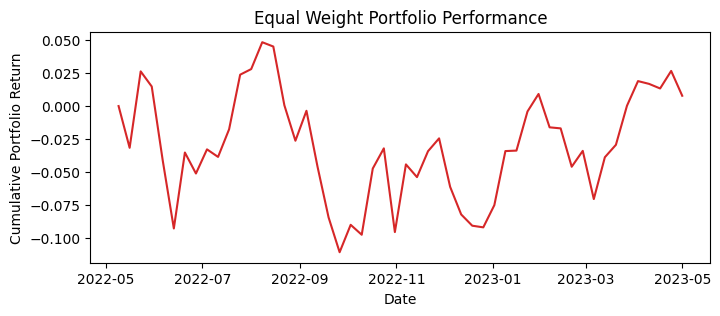

In [28]:
eq_portfolio = (1 + portfolio_returns).cumprod() - 1
eq_maxdd = min(eq_portfolio)

# Plot cumulative returns over time
plt.figure(figsize=(8,3))
plt.plot(portfolio_returns.index, eq_portfolio, color='tab:red')
plt.title('Equal Weight Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Portfolio Return')
plt.show()

## MVO Portfolio

In [29]:
#MVO
weights = {asset: weight for asset, weight in zip(stock_returns.columns, weights_sharpe)}

weighted_returns = stock_returns * pd.Series(weights)

portfolio_returns = weighted_returns.sum(axis=1)

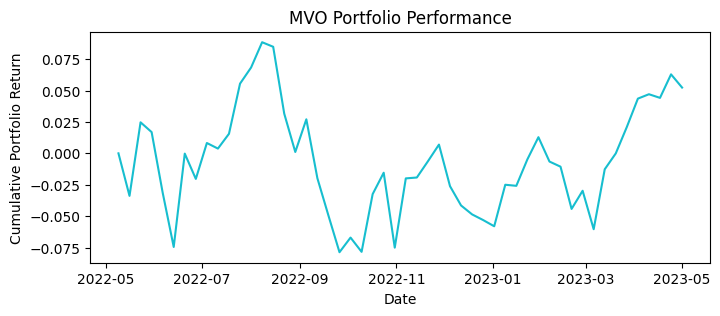

In [30]:
# Calculate cumulative returns
mvo_portfolio = (1 + portfolio_returns).cumprod() - 1
mvo_maxdd =  min(mvo_portfolio)
# Plot cumulative returns over time
plt.figure(figsize=(8,3))
plt.plot(portfolio_returns.index, mvo_portfolio, color='tab:cyan')
plt.title('MVO Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Portfolio Return')
plt.show()

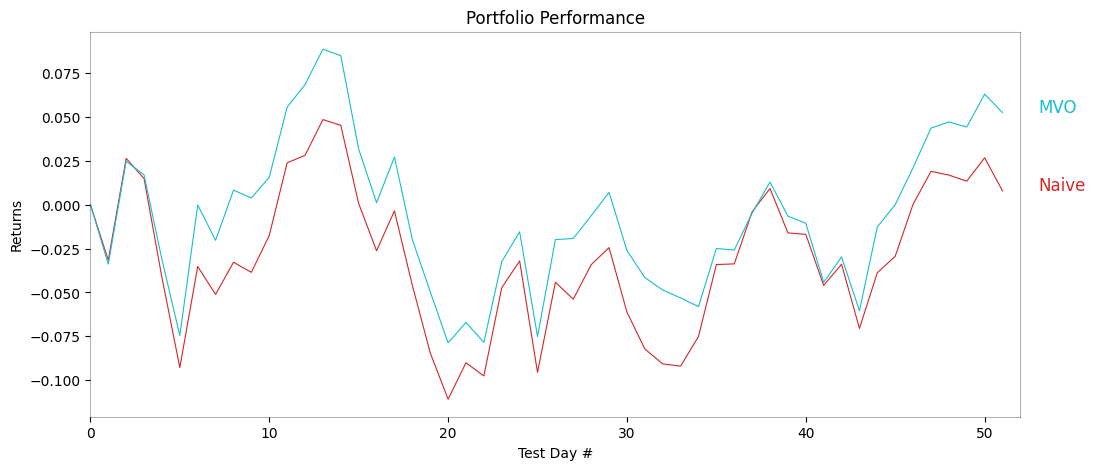

In [31]:
plt.figure(figsize=(12,5))
plt.plot(eq_portfolio.to_numpy(), lw=0.8, color='tab:red')
plt.plot(mvo_portfolio.to_numpy(), lw=0.8, color='tab:cyan')

plt.text(53, eq_portfolio[-1:].values[0], 'Naive', fontsize=12, color='tab:red')
plt.text(53, mvo_portfolio[-1:].values[0], 'MVO', fontsize=12, color='tab:cyan')

plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.xlim(0, 52)
plt.title('Portfolio Performance')
plt.xlabel('Test Day #')
plt.ylabel('Returns')

plt.show()

Here we can see that MVO produces a superior model to a naïve approach of equal weighted portfolio. Thus, MVO is the new high water mark to beat. 

# LSTM 

In [32]:
def shapeForecast(f):
    for key in f:
        f[key] = f[key][0, :, 0].flatten()

In [33]:
shaped_forecasts = forecasts.copy()
shapeForecast(shaped_forecasts)
shaped_forecasts = pd.DataFrame(shaped_forecasts)

In [34]:
assets = []
for i in range(len(tickers)):
    assets.append(Asset(shaped_forecasts.columns[i], shaped_forecasts[shaped_forecasts.columns[i]]))
assets = tuple(assets)
assets

(<Asset name=AAPL, expected return=0.3847562813623893>,
 <Asset name=AMZN, expected return=1.5057766068914338>,
 <Asset name=CVX, expected return=0.9905442881502394>,
 <Asset name=DIS, expected return=0.6025038720000785>,
 <Asset name=GOOGL, expected return=1.6014201910760122>,
 <Asset name=HD, expected return=0.8438782376527489>,
 <Asset name=JNJ, expected return=0.550958908046713>,
 <Asset name=MSFT, expected return=1.047101454420636>,
 <Asset name=PG, expected return=1.1371374814885262>,
 <Asset name=UNH, expected return=0.5764103264598038>,
 <Asset name=V, expected return=1.3493766968907337>,
 <Asset name=WBD, expected return=0.4130953256017745>)

In [35]:
portfolio = Portfolio(assets)

portfolio.optimize_sharpe_ratio
weights_sharpe = portfolio.weights.flatten()

display(
  pd.DataFrame(list(zip([asset.name for asset in portfolio.assets], weights_sharpe )), 
               columns=['asset', 'optimize_sharpe_ratio()',]))

,asset,optimize_sharpe_ratio()
0,AAPL,0.12099
1,AMZN,0.05258
2,CVX,0.00984
3,DIS,0.11135
4,GOOGL,0.04415
5,HD,0.06426
6,JNJ,0.13091
7,MSFT,0.09293
8,PG,0.11991
9,UNH,0.13132


In [36]:
weights = {asset: weight for asset, weight in zip(stock_returns.columns, weights_sharpe)}

weighted_returns = stock_returns * pd.Series(weights)

portfolio_returns = weighted_returns.sum(axis=1)

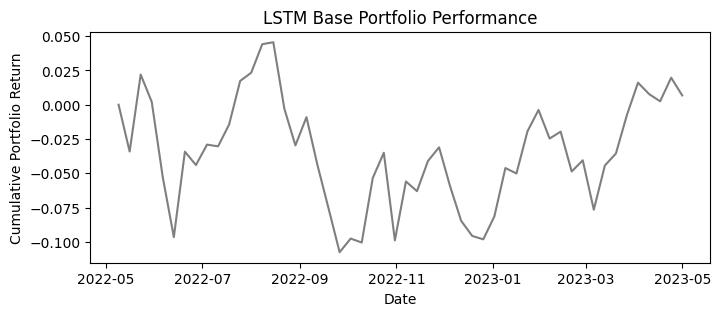

In [37]:
# Calculate cumulative returns
lstm = (1 + portfolio_returns).cumprod() - 1
lstm_maxdd =  min(lstm)
# Plot cumulative returns over time
plt.figure(figsize=(8,3))
plt.plot(portfolio_returns.index, lstm, color='tab:grey')
plt.title('LSTM Base Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Portfolio Return')
plt.show()

## LSTM + CNN

In [ ]:
def shapeForecast2(f):
    for key in f:
        f[key] = f[key][ :, 0].flatten()

In [ ]:
#format model forecasts
shaped_forecasts = forecasts_4.copy()
shapeForecast2(shaped_forecasts)
shaped_forecasts = pd.DataFrame(shaped_forecasts)

#mvo
assets = []
for i in range(len(tickers)):
    assets.append(Asset(shaped_forecasts.columns[i], shaped_forecasts[shaped_forecasts.columns[i]]))
assets = tuple(assets)
portfolio = Portfolio(assets)
portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

#portfolio returns
weights = {asset: weight for asset, weight in zip(stock_returns.columns, weights_sharpe)}
weighted_returns = stock_returns * pd.Series(weights)
portfolio_returns = weighted_returns.sum(axis=1)

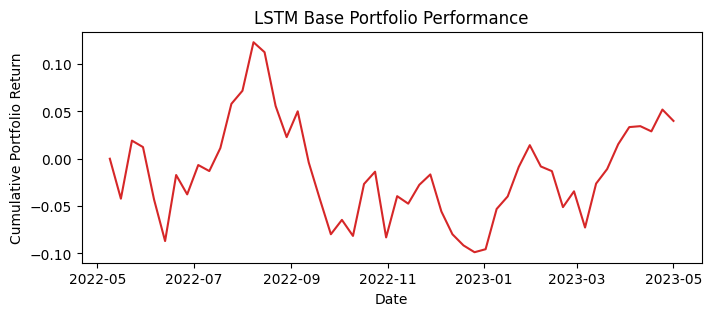

In [ ]:
# Calculate cumulative returns
lstm_cnn = (1 + portfolio_returns).cumprod() - 1
lstm_cnn_maxdd =  min(lstm_cnn)
# Plot cumulative returns over time
plt.figure(figsize=(8,3))
plt.plot(portfolio_returns.index, lstm_cnn, color='tab:red')
plt.title('LSTM Base Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Portfolio Return')
plt.show()

## Final Results

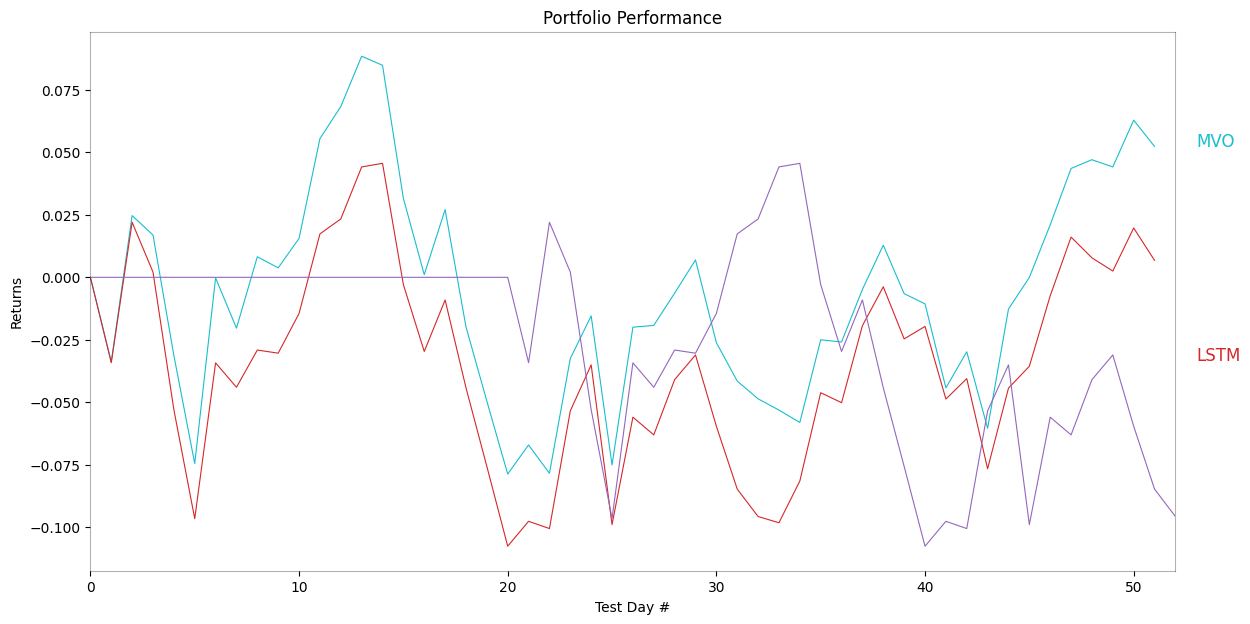

In [38]:
plt.figure(figsize=(14,7))
plt.plot(mvo_portfolio.to_numpy(), lw=0.8, color='tab:cyan')
plt.plot(lstm.to_numpy(), lw=0.8, color='tab:red')
# plt.plot(lstm_gru.to_numpy(), lw=0.8, color='tab:green')
# plt.plot(lstm_gru_att.to_numpy(), lw=0.8, color='tab:purple')
# plt.plot(lstm_cnn.to_numpy(), lw=0.8, color='tab:red')
plt.plot(np.append(np.zeros(20), lstm), lw=0.8, color='tab:purple')

# plt.text(53, eq_portfolio[-1:].values[0], '+CNN', fontsize=12, color='tab:red')
plt.text(53, mvo_portfolio[-1:].values[0], 'MVO', fontsize=12, color='tab:cyan')
plt.text(53, lstm[-1]-0.04, 'LSTM', fontsize=12, color='tab:red')
# plt.text(53, lstm_gru[-1], '+GRU', fontsize=12, color='tab:green')
# plt.text(53, lstm_gru_att[-1], '+GRU+ATT', fontsize=12, color='tab:purple')

plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.xlim(0, 52)
plt.title('Portfolio Performance')
plt.xlabel('Test Day #')
plt.ylabel('Returns')

plt.show()

Text(0, 0.5, 'Returns')

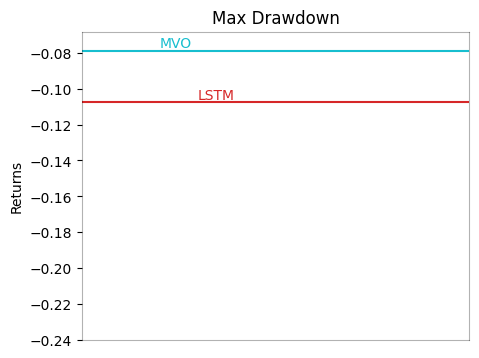

In [39]:
plt.figure(figsize=(5,4))
# plt.axhline(lstm_cnn_maxdd, color= 'tab:red')
plt.axhline(mvo_maxdd, color= 'tab:cyan')
plt.axhline(lstm_maxdd, color= 'tab:red')
# plt.axhline(lstm_gru_maxdd, color= 'tab:green')
# plt.axhline(lstm_gru_att_maxdd, color= 'tab:purple')

# plt.text(0.1, lstm_cnn_maxdd+0.002, 'LSTM+CNN', fontsize=10, color='tab:red')
plt.text(0.2, mvo_maxdd+0.002, 'MVO', fontsize=10, color='tab:cyan')
plt.text(0.3, lstm_maxdd+0.002, 'LSTM', fontsize=10, color='tab:red')
# plt.text(0.4, lstm_gru_maxdd+0.002, 'LSTM+GRU', fontsize=10, color='tab:green')
# plt.text(0.2, lstm_gru_att_maxdd+0.002, 'LSTM+GRU+ATT', fontsize=10, color='tab:purple')

plt.xticks([])
plt.gca().spines["top"].set_alpha(.3)
plt.gca().spines["bottom"].set_alpha(.3)
plt.gca().spines["right"].set_alpha(.3)
plt.gca().spines["left"].set_alpha(.3)

plt.ylim(-.24, -.068)
plt.title('Max Drawdown')
plt.ylabel('Returns')